# Extraction

In [1]:
%matplotlib inline

from datasets import load_dataset
from pathlib import Path
import json
import random
import sys
import matplotlib.pyplot as plt
from PIL import Image as PILImage
from IPython.display import display
from openai import AsyncOpenAI
from tqdm import tqdm

# Add parent directory to path for src imports
sys.path.insert(0, str(Path("..").resolve()))

# Import from src modules
from src import (
    convert_docs_to_pdf,
    process_pdfs_with_mineru,
    extract_tables_from_output,
    merge_consecutive_tables,
    find_summary_compensation_in_doc,
    extract_all_summary_compensation,
    save_classification_results,
    save_extraction_results,
    display_all_results,
    display_table_preview,
    TableType
)

# Base path (project root)
BASE_PATH = Path("..").resolve()

# Setup directories
(BASE_PATH / "pdfs").mkdir(exist_ok=True)
(BASE_PATH / "output").mkdir(exist_ok=True)

# Load dataset and sample random docs
dataset = load_dataset("json", data_files=str(BASE_PATH / "data/DEF14A_all.jsonl"))  # or from HF: pierjoe/SEC-DEF14A-2005-2022
all_docs = dataset["train"]

random.seed(35236236)
indices = random.sample(range(len(all_docs)), 10_000)
docs = all_docs.select(indices)

# Setup VLM client
client = AsyncOpenAI(base_url="http://localhost:8000/v1", api_key="dummy")
MODEL = "Qwen/Qwen3-VL-32B-Instruct"

/home/pdipasquale/MIIA/stuff/.stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
convert_docs_to_pdf(docs, base_path=BASE_PATH)
failed, success = process_pdfs_with_mineru(base_path=BASE_PATH, max_concurrent=16)
all_tables, extraction_stats = extract_tables_from_output(output_path=BASE_PATH / "output", save_path=str(BASE_PATH / "all_tables.json"))

with open(BASE_PATH / "all_tables.json") as f:
    all_tables = json.load(f)

  1%|          | 116/10000 [00:20<36:57,  4.46it/s]

In [ ]:
# Count documents without tables
doc_sources = set(t.get('source_doc') for t in all_tables)
all_output_dirs = {d.name for d in (BASE_PATH / "output").iterdir() if d.is_dir()}
missing = all_output_dirs - doc_sources
print(f"Documents with tables: {len(doc_sources)}")
print(f"Documents without tables: {len(missing)}")

Documents with tables: 244
Documents without tables: 6


# EXTRACT ONE

In [4]:

n = 110
doc_sources = list(set(t.get('source_doc') for t in all_tables))

source_doc = doc_sources[n]
metadata_path = BASE_PATH / "output" / source_doc / "metadata.json"

with open(metadata_path) as f:
                meta = json.load(f)
if meta["sic"] == "NULL":
    print("-----------FONDO----------")
# meta
# 38, 55, 99, 108(non pagano)

In [ ]:
found, all_classifications = await find_summary_compensation_in_doc(
    doc_source=source_doc,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    display_func=display,
    plt_module=plt,
    pil_image_class=PILImage,
    debug=False
)

source_doc = found[0]['table']['source_doc']
images_base_dir = BASE_PATH / f"output/{source_doc}/{source_doc}/vlm"

found = merge_consecutive_tables(found, images_base_dir, all_tables, all_classifications, debug=True)

Found 1 Summary Compensation Tables

🔍 Starting merge from table 5 (page 21, has_header=True)
   ❌ Table on page 22 too far (not adjacent page or not at top)
   ℹ️ No tables to merge, keeping as-is


✓ Extracted table 5: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1448597_2021_0001104659-21-086772/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1448597_2021_0001104659-21-086772/extraction_results.json


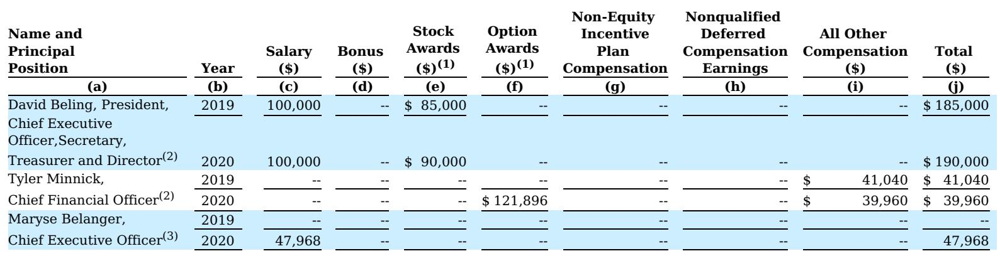

In [6]:
extracted = await extract_all_summary_compensation(
    found_tables=found,
    all_tables=all_tables,
    client=client,
    model=MODEL,
    base_path=BASE_PATH,
    metadata=meta
)
save_classification_results(found, BASE_PATH / "output" / source_doc, metadata=meta)
save_extraction_results(extracted, BASE_PATH / "output" / source_doc, metadata=meta)
display_all_results(
    extracted_list=extracted,
    found_tables=found,
    metadata=meta,
    base_path=BASE_PATH,
    pil_image_class=PILImage
)

# EXTRACT MULTIPLE

In [ ]:
doc_sources = list(set(t.get('source_doc') for t in all_tables))

for source_doc in tqdm(doc_sources, desc="Processing"):
    # Carica metadata
    metadata_path = BASE_PATH / "output" / source_doc / "metadata.json"
    with open(metadata_path) as f:
        meta = json.load(f)
    
    # Salta i fondi (no SIC)
    if meta.get("sic") == "NULL" or meta.get("sic") is None:
        continue
    
    # Salta se già processato
    if (BASE_PATH / "output" / source_doc / "extraction_results.json").exists():
        continue
    
    try:
        # Classifica
        found, all_classifications = await find_summary_compensation_in_doc(
            doc_source=source_doc,
            all_tables=all_tables,
            client=client,
            model=MODEL,
            base_path=BASE_PATH,
            display_func=display,
            plt_module=plt,
            pil_image_class=PILImage,
            debug=False
        )
        
        if not found:
            continue
        
        # Merge
        images_base_dir = BASE_PATH / f"output/{source_doc}/{source_doc}/vlm"
        found = merge_consecutive_tables(found, images_base_dir, all_tables, all_classifications, debug=False)
        
        # Estrai
        extracted = await extract_all_summary_compensation(
            found_tables=found,
            all_tables=all_tables,
            client=client,
            model=MODEL,
            base_path=BASE_PATH,
            metadata=meta
        )
        
        # Salva
        save_classification_results(found, BASE_PATH / "output" / source_doc, metadata=meta)
        save_extraction_results(extracted, BASE_PATH / "output" / source_doc, metadata=meta)
        
    except Exception as e:
        tqdm.write(f"✗ Error {source_doc}: {e}")

Processing:   0%|          | 0/244 [00:00<?, ?it/s]

Found 3 Summary Compensation Tables
✓ Extracted table 9: 1 executives
✓ Extracted table 14: 11 executives


Processing:   0%|          | 1/244 [01:15<5:07:05, 75.82s/it]

✓ Extracted table 15: 10 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/107687_2017_0000107687-17-000098/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/107687_2017_0000107687-17-000098/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   1%|          | 2/244 [01:53<3:35:45, 53.49s/it]

✓ Extracted table 10: 9 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1209028_2011_0001193125-11-105498/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1209028_2011_0001193125-11-105498/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   1%|          | 3/244 [02:53<3:45:53, 56.24s/it]

✓ Extracted table 11: 16 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1024305_2019_0001024305-19-000109/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1024305_2019_0001024305-19-000109/extraction_results.json


Processing:   2%|▏         | 4/244 [03:04<2:34:38, 38.66s/it]

Found 0 Summary Compensation Tables
Found 1 Summary Compensation Tables


Processing:   2%|▏         | 5/244 [03:47<2:39:01, 39.92s/it]

✓ Extracted table 7: 14 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1596946_2015_0001564590-15-005718/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1596946_2015_0001564590-15-005718/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   2%|▏         | 6/244 [04:37<2:52:11, 43.41s/it]

✓ Extracted table 8: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/896264_2020_0001047469-20-001639/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/896264_2020_0001047469-20-001639/extraction_results.json


Processing:   3%|▎         | 7/244 [04:49<2:11:38, 33.33s/it]

Found 1 Summary Compensation Tables
✗ Error 826154_2005_0001168557-05-000015: [Errno 21] Is a directory: 'output/826154_2005_0001168557-05-000015/826154_2005_0001168557-05-000015/vlm'
Found 1 Summary Compensation Tables


Processing:   4%|▎         | 9/244 [05:16<1:32:27, 23.60s/it]

✓ Extracted table 7: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1337068_2018_0001174947-18-001550/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1337068_2018_0001174947-18-001550/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   4%|▍         | 10/244 [06:06<1:58:42, 30.44s/it]

✓ Extracted table 9: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1315255_2018_0001398344-18-006199/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1315255_2018_0001398344-18-006199/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   5%|▍         | 12/244 [06:28<1:25:59, 22.24s/it]

✓ Extracted table 1: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1288946_2008_0001144204-08-066665/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1288946_2008_0001144204-08-066665/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   5%|▌         | 13/244 [08:07<2:34:15, 40.07s/it]

✓ Extracted table 48: 11 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/921582_2020_0001564590-20-019816/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/921582_2020_0001564590-20-019816/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   6%|▌         | 14/244 [08:31<2:18:32, 36.14s/it]

✓ Extracted table 3: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1539894_2022_0001539894-22-000028/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1539894_2022_0001539894-22-000028/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   6%|▌         | 15/244 [09:14<2:24:49, 37.95s/it]

✓ Extracted table 3: 17 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1086745_2006_0001013762-06-001685/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1086745_2006_0001013762-06-001685/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   7%|▋         | 16/244 [09:45<2:16:20, 35.88s/it]

✓ Extracted table 9: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1645569_2022_0001564590-22-015687/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1645569_2022_0001564590-22-015687/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   7%|▋         | 17/244 [10:41<2:37:26, 41.62s/it]

✓ Extracted table 9: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1293971_2016_0001564590-16-016447/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1293971_2016_0001564590-16-016447/extraction_results.json
Found 2 Summary Compensation Tables
✓ Extracted table 5: 5 executives


Processing:   7%|▋         | 18/244 [11:25<2:39:30, 42.35s/it]

✓ Extracted table 6: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/110536_2007_0001104659-07-043948/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/110536_2007_0001104659-07-043948/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   8%|▊         | 19/244 [12:18<2:49:58, 45.33s/it]

✓ Extracted table 9: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/836157_2013_0001193125-13-477224/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/836157_2013_0001193125-13-477224/extraction_results.json
Found 5 Summary Compensation Tables
✓ Extracted table 0: 3 executives
✓ Extracted table 14: 4 executives
✓ Extracted table 18: 3 executives
✓ Extracted table 20: 10 executives


Processing:   9%|▊         | 21/244 [14:22<3:16:59, 53.00s/it]

✓ Extracted table 23: 13 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/927628_2020_0001193125-20-079122/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/927628_2020_0001193125-20-079122/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   9%|▉         | 22/244 [14:49<2:52:32, 46.63s/it]

✓ Extracted table 0: 9 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/947559_2005_0001030798-05-000033/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/947559_2005_0001030798-05-000033/extraction_results.json
Found 1 Summary Compensation Tables


Processing:   9%|▉         | 23/244 [15:39<2:54:20, 47.33s/it]

✓ Extracted table 2: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1013272_2016_0000946275-16-000249/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1013272_2016_0000946275-16-000249/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  10%|▉         | 24/244 [16:37<3:04:41, 50.37s/it]

✓ Extracted table 6: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1024657_2014_0001193125-14-139698/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1024657_2014_0001193125-14-139698/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  10%|█         | 25/244 [17:34<3:10:36, 52.22s/it]

✓ Extracted table 12: 9 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/807882_2009_0000936392-09-000009/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/807882_2009_0000936392-09-000009/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  11%|█         | 26/244 [18:16<2:58:32, 49.14s/it]

✓ Extracted table 6: 11 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/313395_2008_0000950129-08-002477/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/313395_2008_0000950129-08-002477/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  11%|█▏        | 28/244 [18:52<2:07:07, 35.31s/it]

✓ Extracted table 4: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/750558_2006_0001144204-06-015188/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/750558_2006_0001144204-06-015188/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  12%|█▏        | 29/244 [19:25<2:03:56, 34.59s/it]

✓ Extracted table 13: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1044378_2019_0001564590-19-013999/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1044378_2019_0001564590-19-013999/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  12%|█▏        | 30/244 [20:14<2:17:15, 38.49s/it]

✓ Extracted table 16: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1109354_2010_0001047469-10-003717/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1109354_2010_0001047469-10-003717/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  13%|█▎        | 32/244 [21:38<2:20:56, 39.89s/it]

✓ Extracted table 20: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1054905_2013_0001193125-13-120692/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1054905_2013_0001193125-13-120692/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  14%|█▎        | 33/244 [22:13<2:16:22, 38.78s/it]

✓ Extracted table 8: 8 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1174872_2008_0001193125-08-091078/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1174872_2008_0001193125-08-091078/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  14%|█▍        | 34/244 [23:59<3:13:49, 55.38s/it]

✓ Extracted table 25: 14 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/93410_2021_0001193125-21-109793/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/93410_2021_0001193125-21-109793/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  14%|█▍        | 35/244 [24:25<2:46:02, 47.67s/it]

✓ Extracted table 5: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1598665_2018_0001193125-18-128888/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1598665_2018_0001193125-18-128888/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  15%|█▌        | 37/244 [26:08<2:50:16, 49.36s/it]

✓ Extracted table 22: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/4281_2016_0001193125-16-515432/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/4281_2016_0001193125-16-515432/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  16%|█▌        | 38/244 [26:52<2:45:20, 48.16s/it]

✓ Extracted table 9: 14 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/948844_2006_0000950136-06-002720/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/948844_2006_0000950136-06-002720/extraction_results.json
Found 2 Summary Compensation Tables
✓ Extracted table 13: 5 executives


Processing:  16%|█▌        | 39/244 [28:04<3:05:01, 54.15s/it]

✓ Extracted table 15: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1396033_2021_0001104659-21-047333/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1396033_2021_0001104659-21-047333/extraction_results.json
Found 2 Summary Compensation Tables
✓ Extracted table 9: 6 executives


Processing:  16%|█▋        | 40/244 [29:47<3:47:55, 67.04s/it]

✓ Extracted table 21: 18 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1475922_2014_0001193125-14-123135/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1475922_2014_0001193125-14-123135/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  17%|█▋        | 42/244 [30:05<2:21:41, 42.09s/it]

✓ Extracted table 2: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1510964_2014_0001019687-14-002627/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1510964_2014_0001019687-14-002627/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  18%|█▊        | 43/244 [30:43<2:18:06, 41.23s/it]

✓ Extracted table 4: 14 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1624512_2019_0001493152-19-015772/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1624512_2019_0001493152-19-015772/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  18%|█▊        | 44/244 [31:10<2:05:14, 37.57s/it]

✓ Extracted table 1: 9 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/42316_2005_0001003297-05-000122/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/42316_2005_0001003297-05-000122/extraction_results.json


Processing:  19%|█▉        | 46/244 [31:13<1:13:52, 22.39s/it]

Found 0 Summary Compensation Tables
Found 5 Summary Compensation Tables
✓ Extracted table 9: 6 executives
✓ Extracted table 10: 2 executives
✓ Extracted table 11: 2 executives
✓ Extracted table 12: 2 executives


Processing:  19%|█▉        | 47/244 [32:05<1:35:58, 29.23s/it]

✓ Extracted table 13: 2 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1273685_2009_0001144204-09-022549/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1273685_2009_0001144204-09-022549/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  20%|█▉        | 48/244 [32:25<1:28:34, 27.12s/it]

✓ Extracted table 5: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1060455_2010_0000950123-10-032123/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1060455_2010_0000950123-10-032123/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  20%|██        | 49/244 [33:18<1:49:42, 33.76s/it]

✓ Extracted table 10: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/745981_2016_0000745981-16-000084/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/745981_2016_0000745981-16-000084/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  21%|██        | 51/244 [34:08<1:36:49, 30.10s/it]

✓ Extracted table 8: 9 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/789073_2008_0001193125-08-049027/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/789073_2008_0001193125-08-049027/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  22%|██▏       | 53/244 [35:17<1:40:36, 31.60s/it]

✓ Extracted table 13: 15 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/742112_2015_0000742112-15-000026/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/742112_2015_0000742112-15-000026/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  22%|██▏       | 54/244 [35:47<1:39:25, 31.40s/it]

✓ Extracted table 2: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1270436_2016_0001047469-16-016632/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1270436_2016_0001047469-16-016632/extraction_results.json
Found 2 Summary Compensation Tables
✓ Extracted table 27: 13 executives


Processing:  23%|██▎       | 55/244 [37:37<2:36:30, 49.68s/it]

✓ Extracted table 29: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/16732_2019_0001206774-19-003416/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/16732_2019_0001206774-19-003416/extraction_results.json
Found 2 Summary Compensation Tables
✓ Extracted table 5 [MERGED]: 6 executives


Processing:  23%|██▎       | 56/244 [38:01<2:15:38, 43.29s/it]

✓ Extracted table 6: 3 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1169424_2005_0001019056-05-000410/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1169424_2005_0001019056-05-000410/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  23%|██▎       | 57/244 [38:45<2:15:42, 43.54s/it]

✓ Extracted table 8: 9 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/912463_2020_0001193125-20-142256/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/912463_2020_0001193125-20-142256/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  24%|██▍       | 58/244 [39:03<1:53:07, 36.49s/it]

✓ Extracted table 2: 4 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1602078_2022_0001079973-22-000870/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1602078_2022_0001079973-22-000870/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  24%|██▍       | 59/244 [39:23<1:38:33, 31.96s/it]

✓ Extracted table 1: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/744825_2005_0000950134-05-008419/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/744825_2005_0000950134-05-008419/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  25%|██▍       | 60/244 [39:41<1:25:25, 27.85s/it]

✓ Extracted table 3: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/98338_2013_0001213900-13-005290/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/98338_2013_0001213900-13-005290/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  25%|██▌       | 61/244 [40:01<1:18:01, 25.58s/it]

✓ Extracted table 2: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1399352_2013_0001477932-13-005645/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1399352_2013_0001477932-13-005645/extraction_results.json
Found 2 Summary Compensation Tables
✓ Extracted table 20: 13 executives


Processing:  25%|██▌       | 62/244 [41:40<2:23:14, 47.22s/it]

✓ Extracted table 23: 13 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/716133_2015_0000716133-15-000018/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/716133_2015_0000716133-15-000018/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  26%|██▌       | 63/244 [42:15<2:11:29, 43.59s/it]

✓ Extracted table 10: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1260968_2007_0000893220-07-001428/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1260968_2007_0000893220-07-001428/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  26%|██▌       | 64/244 [43:01<2:12:28, 44.16s/it]

✓ Extracted table 4: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/771266_2018_0001193125-18-103419/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/771266_2018_0001193125-18-103419/extraction_results.json
Found 3 Summary Compensation Tables
✓ Extracted table 7: 15 executives
✓ Extracted table 12: 13 executives


Processing:  27%|██▋       | 66/244 [44:35<2:14:55, 45.48s/it]

✓ Extracted table 18: 4 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1289460_2020_0001047469-20-002071/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1289460_2020_0001047469-20-002071/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  28%|██▊       | 68/244 [45:28<1:51:19, 37.95s/it]

✓ Extracted table 11: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1444380_2018_0001564590-18-007779/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1444380_2018_0001564590-18-007779/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  28%|██▊       | 69/244 [46:45<2:15:46, 46.55s/it]

✓ Extracted table 16: 16 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/875159_2012_0000930413-12-001490/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/875159_2012_0000930413-12-001490/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  29%|██▉       | 71/244 [47:28<1:46:39, 36.99s/it]

✓ Extracted table 1: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1018005_2012_0001018005-12-000035/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1018005_2012_0001018005-12-000035/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  30%|██▉       | 72/244 [48:15<1:51:46, 38.99s/it]

✓ Extracted table 5: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/916235_2009_0001145443-09-002440/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/916235_2009_0001145443-09-002440/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  30%|██▉       | 73/244 [49:14<2:04:28, 43.68s/it]

✓ Extracted table 7: 18 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/795266_2007_0000950124-07-001309/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/795266_2007_0000950124-07-001309/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  31%|███       | 75/244 [49:43<1:30:24, 32.10s/it]

✓ Extracted table 6: 5 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1373980_2011_0001140361-11-022553/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1373980_2011_0001140361-11-022553/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  31%|███       | 76/244 [50:47<1:49:27, 39.09s/it]

✓ Extracted table 11: 14 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1096752_2012_0001193125-12-494881/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1096752_2012_0001193125-12-494881/extraction_results.json


Processing:  32%|███▏      | 77/244 [51:01<1:31:53, 33.02s/it]

Found 1 Summary Compensation Tables
✗ Error 1181001_2006_0000950133-06-002138: [Errno 21] Is a directory: 'output/1181001_2006_0000950133-06-002138/1181001_2006_0000950133-06-002138/vlm'
Found 1 Summary Compensation Tables


Processing:  32%|███▏      | 79/244 [51:45<1:18:38, 28.60s/it]

✓ Extracted table 5: 12 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1350653_2012_0001193125-12-196578/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1350653_2012_0001193125-12-196578/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  33%|███▎      | 80/244 [52:51<1:41:00, 36.96s/it]

✓ Extracted table 13: 16 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1062478_2011_0000950123-11-035168/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1062478_2011_0000950123-11-035168/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  33%|███▎      | 81/244 [53:12<1:30:14, 33.22s/it]

✓ Extracted table 2: 6 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/922237_2009_0000950123-09-061793/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/922237_2009_0000950123-09-061793/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  34%|███▎      | 82/244 [53:37<1:23:47, 31.04s/it]

✓ Extracted table 2: 8 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1582554_2019_0001493152-19-014508/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1582554_2019_0001493152-19-014508/extraction_results.json
Found 1 Summary Compensation Tables


Processing:  35%|███▍      | 85/244 [54:45<1:10:35, 26.64s/it]

✓ Extracted table 12: 18 executives
💾 Classification results saved to: /home/pdipasquale/MIIA/stuff/output/1000694_2014_0001144204-14-026440/classification_results.json
💾 Extraction results saved to: /home/pdipasquale/MIIA/stuff/output/1000694_2014_0001144204-14-026440/extraction_results.json
